### 1. Setup and Load Data

#### 1.1 Install dependencies and setup

In [269]:
import tensorflow as tf
import os 
import matplotlib.pyplot as plt

In [270]:
# Avoid OOM (Out Of Memory) error by setting up GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

#### 1.2 Remove dodgy images

In [271]:
import cv2
import imghdr

In [272]:
data_dir = '/Users/rahulsharma/Desktop/ImageClassification/data'

In [273]:
# os.listdir(os.path.join(data_dir,'happy'))

In [274]:
image_exts = ['jpg','jpeg','bmp','png']


In [275]:
for image_class in os.listdir(data_dir): 
    image_class_path = os.path.join(data_dir, image_class)
    if os.path.isdir(image_class_path):
        for image in os.listdir(image_class_path):
            image_path = os.path.join(image_class_path, image)
            try: 
                img = cv2.imread(image_path)
                tip = imghdr.what(image_path)
                if tip not in image_exts: 
                    print('Image not in ext list {}'.format(image_path))
                    os.remove(image_path)
            except Exception as e: 
                print('Issue with image {}'.format(image_path))
                # os.remove(image_path)
    else:
        print(f'Skipping non-directory entry: {image_class_path}')

Skipping non-directory entry: /Users/rahulsharma/Desktop/ImageClassification/data/.DS_Store


#### 1.3 Load the data

In [276]:
tf.keras.utils.image_dataset_from_directory

<function keras.src.utils.image_dataset.image_dataset_from_directory(directory, labels='inferred', label_mode='int', class_names=None, color_mode='rgb', batch_size=32, image_size=(256, 256), shuffle=True, seed=None, validation_split=None, subset=None, interpolation='bilinear', follow_links=False, crop_to_aspect_ratio=False, **kwargs)>

In [277]:
data = tf.keras.utils.image_dataset_from_directory('data')

Found 258 files belonging to 2 classes.


The above step acts as a generator and the in order us to grab the data we use a numpy  iterator and then we can get consecutive batches using the `.next()` method

In [278]:
data_iterator = data.as_numpy_iterator()
batch = data_iterator.next()

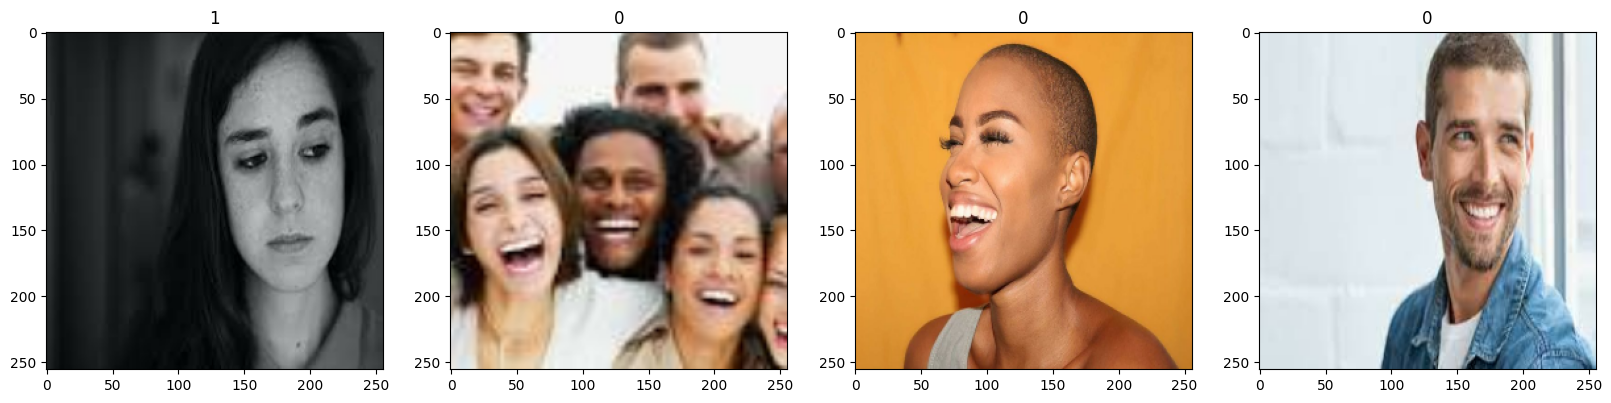

In [279]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])


### 2. Preprocess Data

#### 2.1 Scale data

We do this as we're loading the data into the data pipeline. `data.map()` allows us to perform the transformation in the pipeline. 

In [280]:
data = data.map(lambda x,y: (x/255, y))

In [281]:
# scaled = data.as_numpy_iterator()
# batch = scaled.next()
# batch[0].max()

#### 2.2 Split data

In [282]:
# train_size = int(len(data)*0.7)
# test_size = int(len(data)*0.2)
# val_size = int(len(data)*0.1)

In [283]:
# train = data.take(train_size)
# test = data.skip(train_size).take(test_size)
# val = data.skip(train_size+test_size).take(val_size)

In [284]:
# print(len(train))
# print(len(test)) 
# print(len(val))

In [285]:

# Calculate sizes
total_size = len(data)
train_size = int(total_size * 0.7)
test_size = int(total_size * 0.2)
val_size = total_size - train_size - test_size

# Split the dataset
train = data.take(train_size)
test = data.skip(train_size).take(test_size)
val = data.skip(train_size + test_size).take(val_size)

# Print sizes
print("Train size:", len(train))
print("Test size:", len(test))
print("Validation size:", len(val))


Train size: 6
Test size: 1
Validation size: 2


### 3. Deep Model

#### 3.1 Building the deep learning model

In [286]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout

In [287]:
model = Sequential()

In [288]:
model.add(Conv2D(16, (3,3), 1, activation='relu', input_shape=(256,256,3)))
model.add(MaxPooling2D())

model.add(Conv2D(32, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())

model.add(Conv2D(16, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())

model.add(Flatten())

model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [289]:
model.compile('adam', loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])
# optimizer, loss function, metric

In [290]:
model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_24 (Conv2D)          (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d_22 (MaxPooli  (None, 127, 127, 16)      0         
 ng2D)                                                           
                                                                 
 conv2d_25 (Conv2D)          (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_23 (MaxPooli  (None, 62, 62, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_26 (Conv2D)          (None, 60, 60, 16)        4624      
                                                                 
 max_pooling2d_24 (MaxPooli  (None, 30, 30, 16)       

#### 3.2 Train

In [291]:
# Creating a log directory
logdir = '/Users/rahulsharma/Desktop/ImageClassification/logs'

In [292]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)
hist = model.fit(train, epochs=20, validation_data=val ,callbacks=[tensorboard_callback])

Epoch 1/20


6/6 [==============================] - 4s 521ms/step - loss: 2.0201 - accuracy: 0.5104 - val_loss: 0.7877 - val_accuracy: 0.4118
Epoch 2/20
6/6 [==============================] - 3s 450ms/step - loss: 0.7072 - accuracy: 0.4635 - val_loss: 0.6424 - val_accuracy: 0.5588
Epoch 3/20
6/6 [==============================] - 3s 425ms/step - loss: 0.6314 - accuracy: 0.6615 - val_loss: 0.5648 - val_accuracy: 0.8529
Epoch 4/20
6/6 [==============================] - 4s 457ms/step - loss: 0.5435 - accuracy: 0.7292 - val_loss: 0.4676 - val_accuracy: 0.8824
Epoch 5/20
6/6 [==============================] - 3s 445ms/step - loss: 0.4670 - accuracy: 0.8438 - val_loss: 0.3846 - val_accuracy: 0.9118
Epoch 6/20
6/6 [==============================] - 3s 434ms/step - loss: 0.3568 - accuracy: 0.8750 - val_loss: 0.3650 - val_accuracy: 0.8529
Epoch 7/20
6/6 [==============================] - 3s 437ms/step - loss: 0.2685 - accuracy: 0.9167 - val_loss: 0.2584 - val_accuracy: 0.9118
Epoch 8/20
6/6 [===============

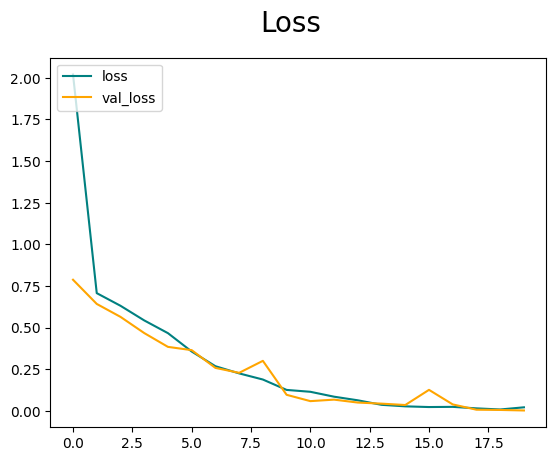

In [293]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

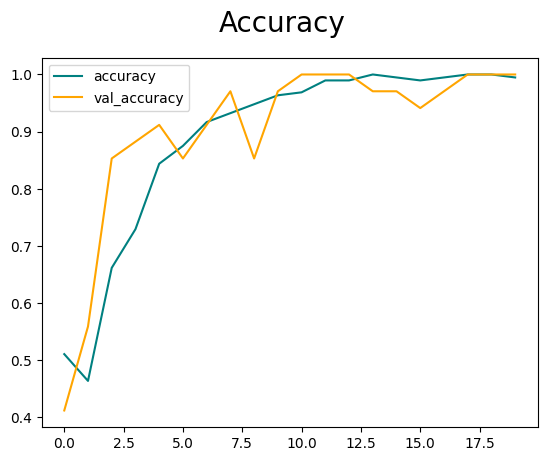

In [294]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

### 4. Evaluate the performance

#### 4.1 Evaluate

In [297]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy
pre = Precision()
re = Recall()
acc = BinaryAccuracy()

In [298]:
for batch in test.as_numpy_iterator(): 
    X, y = batch
    yhat = model.predict(X)
    pre.update_state(y, yhat) #updating the metrics
    re.update_state(y, yhat)
    acc.update_state(y, yhat)

1/1 [==============================] - 0s 255ms/step


In [300]:
print(pre.result(), re.result(), acc.result())

tf.Tensor(1.0, shape=(), dtype=float32) tf.Tensor(1.0, shape=(), dtype=float32) tf.Tensor(1.0, shape=(), dtype=float32)


#### 5. Test

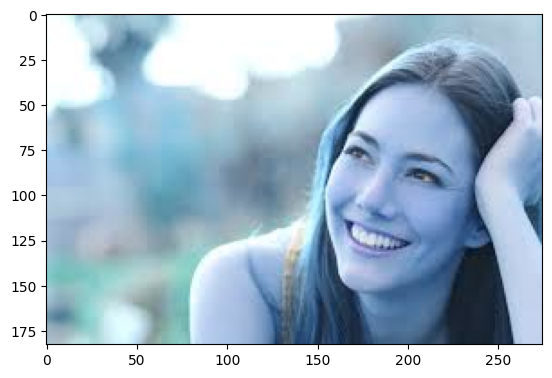

In [308]:
import cv2
img = cv2.imread('/Users/rahulsharma/Desktop/ImageClassification/happytest.jpeg')
plt.imshow(img)
plt.show()

In [310]:
import numpy as np
resize = tf.image.resize(img, (256,256))
yhat = model.predict(np.expand_dims(resize/255, 0))
yhat

1/1 [==============================] - 0s 21ms/step


array([[0.25538972]], dtype=float32)

In [311]:
if yhat > 0.5: 
    print(f'Predicted class is Sad')
else:
    print(f'Predicted class is Happy')

Predicted class is Happy
